In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set() 

# Besoins

Mettre en place un algorithme qui soit capable de différencier automatiquement les vrais des faux billets et, mettre en concurrence deux méthodes  :  
-  méthode 1 : un k-means
-  méthode 2 : une régression logistique 

Cet algorithme se devra d’être naturellement le plus performant possible pour identifier un maximum de faux billets au sein de la masse de billets analysés chaque jour.

Pour une évaluation optimale des modèles, avoir une analyse des nombres de faux positifs et faux négatifs via une matrice de confusion et des scores. 

Enfin, tester l'algorithme sur un jeu de données de production.

# I. Observation

## Lecture des données

On créé un dataframe dfB pour lire les caractéristiques des billets

In [2]:
dfB = pd.read_csv('./billets.csv', sep=';', encoding='UTF-8')
dfB.head(2)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09


In [3]:
dfB.shape

(1500, 7)

Pour l'apprentissage de la détection, une variable sur l'authenticité des billets est présente (is_genuine)

In [4]:
dfB.is_genuine.value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

Sur 1500 billets dans le dataframe, il existe 1000 vrais billets pour 500 faux billets dans l'échantillon

In [5]:
dfB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


Toutes les variables sont de type float, sauf is_genuine qui est boolèenne

## Qualité des données

#### Valeurs manquantes

In [6]:
dfB.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

37 valeurs manquantes sur 1500 dans margin_low

In [7]:
dfB.margin_low.describe()

count    1463.000000
mean        4.485967
std         0.663813
min         2.980000
25%         4.015000
50%         4.310000
75%         4.870000
max         6.900000
Name: margin_low, dtype: float64

Pour ne pas supprimer les lignes concernées, on remplace les valeurs manquantes avec :

## Remplacement des valeurs manquantes : régression linéaire multiple

Il n'est pas possible d'opérer une régression linéaire sur un jeu de données avec des valeurs manquantes : on sépare le dataframe entre 'test' où les valeurs margin_low sont absentes (37 entrées) et 'train' où les valeurs sont présentes (1463 entrées)

In [8]:
test = dfB[dfB['margin_low'].isnull()==True]
test.head(2)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,NaN,3.25,112.79
99,True,171.93,104.07,104.18,NaN,3.14,113.08


In [9]:
train = dfB[dfB['margin_low'].isnull()==False]
train.head(2)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09


On réalise une regression linéaire sur train et on observe les résultats

In [10]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

reg = smf.ols('margin_low~margin_up+length+height_right+height_left+diagonal+is_genuine', data=train).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     390.7
Date:                Mon, 13 Dec 2021   Prob (F-statistic):          4.75e-299
Time:                        13:33:24   Log-Likelihood:                -774.14
No. Observations:                1463   AIC:                             1562.
Df Residuals:                    1456   BIC:                             1599.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.8668      8

On observe : 
- certains paramètres ne sont pas significativement différents de 0, car leur p-valeur n'est pas inférieure à 5 %, le niveau de test souhaité
- Le $R^{2}$ vaut environ 0.61

On teste colinéarité des variables, homoscédasticité et normalité des résidus.

In [11]:
#colinéarité des variables
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
variables = reg.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[4.725732131263029,
 1.5960903251807714,
 3.6132551150015346,
 1.3208356332473372,
 1.1737111515376206,
 1.0281994979080704]

Tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

In [12]:
#Homoscédasticité des résidus (égalité de la variance) des résidus :
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 3.463957971611231e-33


On obtient une p-value inférieure à $5$%, l'hypothèse  $H0$ selon laquelle les variances sont constantes/égales est rejetée

In [13]:
#Normalité des résidus

In [14]:
from scipy.stats import shapiro
shapiro(reg.resid)

ShapiroResult(statistic=0.9936947822570801, pvalue=7.047739472909598e-06)

Ici également, l'hypothèse de normalité des résidus est remise en cause car la p-value est inférieure à $5$%

Néanmoins, le fait que l'échantillon soit de taille suffisante (+1400) par rapport aux valeurs manquantes (63) permet d'utiliser le modèle de regression linéaire pour prédire les valeurs manquantes : il s'agira tout de même de les visualiser

#### Prédiction des valeurs manquantes

Définition de y : les valeurs connues sont considérées comme cible

In [15]:
y = train['margin_low']
y

0       4.52
1       3.77
2       4.40
3       3.62
4       4.04
        ... 
1495    4.42
1496    5.27
1497    5.51
1498    5.17
1499    4.63
Name: margin_low, Length: 1463, dtype: float64

Suppression de margin_low et is_genuine dans train et test

In [16]:
train.drop("margin_low",axis=1,inplace=True)
test.drop("margin_low",axis=1,inplace=True)

/Users/nipeti/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Utilisation de la régression linéaire

In [17]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression() # create object for the class

#On modélise avec train (X=training data) et y (Y=target values)
lr.fit(train,y)  # perform linear regression
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.fit

#On prédit les valeurs avec test (X) comme paramètre
y_pred = lr.predict(test) #Predict using the linear model
y_pred[0:5]

array([4.06495361, 4.11199026, 4.13400328, 3.99357074, 4.1403993 ])

In [18]:
lr.score(train,y)

0.6168760755671029

Le coefficient de détermination de la prédiction ($R^{2}$) est bien de 0.61

In [19]:
test['margin_low']= y_pred
test.head(2)

<ipython-input-19-4366fcff5c7b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['margin_low']= y_pred


,is_genuine,diagonal,height_left,height_right,margin_up,length,margin_low
72,True,171.94,103.89,103.45,3.25,112.79,4.064954
99,True,171.93,104.07,104.18,3.14,113.08,4.111990


In [20]:
train['margin_low']= y
train.head(2)

<ipython-input-20-321e47f473fa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['margin_low']= y


,is_genuine,diagonal,height_left,height_right,margin_up,length,margin_low
0,True,171.81,104.86,104.95,2.89,112.83,4.52
1,True,171.46,103.36,103.66,2.99,113.09,3.77


In [21]:
dfB_pred = pd.concat([test, train], axis=0)
dfB_pred.head(2)

,is_genuine,diagonal,height_left,height_right,margin_up,length,margin_low
72,True,171.94,103.89,103.45,3.25,112.79,4.064954
99,True,171.93,104.07,104.18,3.14,113.08,4.111990


In [22]:
dfB_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 72 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_up     1500 non-null   float64
 5   length        1500 non-null   float64
 6   margin_low    1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 83.5 KB


In [23]:
dfB_pred.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_up       0
length          0
margin_low      0
dtype: int64

In [24]:
dfB_pred.margin_low.describe()

count    1500.000000
mean        4.482844
std         0.659899
min         2.980000
25%         4.027500
50%         4.310000
75%         4.870000
max         6.900000
Name: margin_low, dtype: float64

In [25]:
dfB.margin_low.describe()

count    1463.000000
mean        4.485967
std         0.663813
min         2.980000
25%         4.015000
50%         4.310000
75%         4.870000
max         6.900000
Name: margin_low, dtype: float64

On observe que les valeurs statistiques obtenues avec la prédiction sont proches de celles de l'échantillon d'origine (dfB)

In [26]:
dfB = dfB_pred

#### Autres méthodes

In [27]:
#X = dfB[['margin_low']]

In [28]:

#Méthode KNN Imputer, pour trouver la valeur manquante de la colonne, prendre les caractéristiques des voisins
#from sklearn.impute import KNNImputer
#imputer = KNNImputer(n_neighbors=2, weights="distance")
#X = pd.DataFrame(imputer.fit_transform(X), columns = X.columns)
#X.rename(columns={'margin_low': 'margin_low_filled'}, inplace=True)
#dfB = pd.concat([X['margin_low_filled'], dfB], axis=1)
#dfB.drop('margin_low', axis=1, inplace=True)
#dfB.rename(columns={'margin_low_filled': 'margin_low'}, inplace=True)
#order = [1,2,3,4,0,5,6] # paramétrage de l'ordre des colonnes
#dfB = dfB[[dfB.columns[i] for i in order]]
#dfB.head(1)


In [29]:

#Methode interpolation
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html
#dfB.margin_low.interpolate(method='polynomial', order=2,limit=None, inplace=True)


In [30]:

#Methode pour un remplacement par la moyenne des données de la variable
#dfB.margin_low.fillna(dfB.margin_low.mean(), inplace=True)


## Corrélation

#### Pairplot

On représente les relations par paires sur le dataframe dfB, avec les données booléenne de la variable 'is_genuine' en couleurs

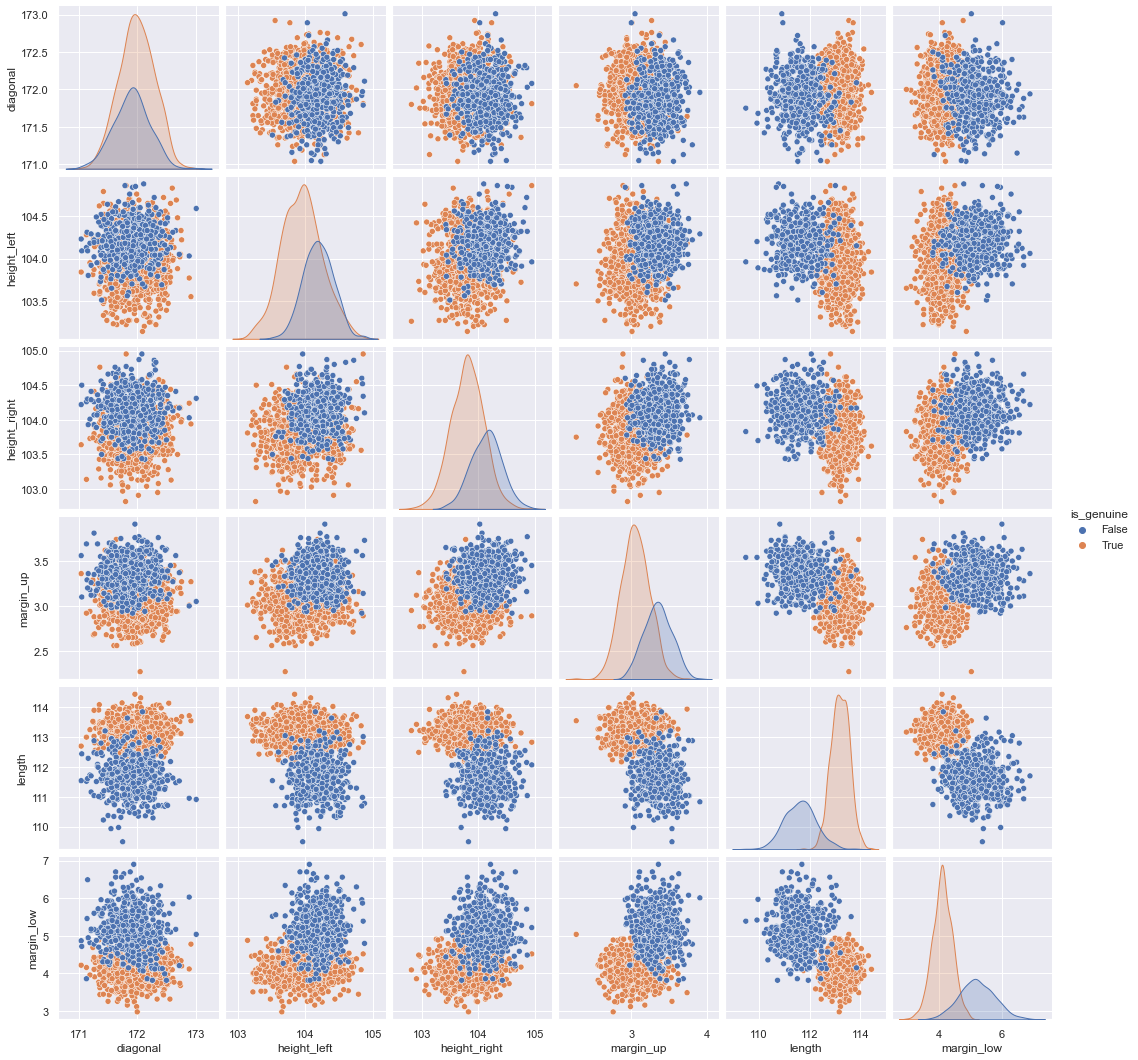

In [31]:
sns.pairplot(dfB, hue='is_genuine')

On observe que les centres des distributions des variables 'margin_low', 'margin_up' et 'length' se distinguent selon les données de la variable 'is_genuine'.  
Ces variables *peuvent* s'avérer significatives pour la détection de vrais/faux billets.

#### Matrices

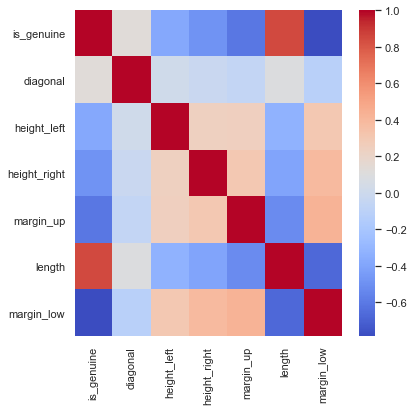

In [32]:
sns.set(rc={'figure.figsize':(6,6)})

df_corr = dfB.corr()

ax = sns.heatmap(df_corr, xticklabels = dfB.columns , 
                 yticklabels = dfB.columns, cmap = 'coolwarm')

In [33]:
cm = sns.light_palette("green", as_cmap=True) 

pd.DataFrame(dfB.corr()).\
style.background_gradient(cmap=cm).set_precision(2)

,is_genuine,diagonal,height_left,height_right,margin_up,length,margin_low
is_genuine,1.00,0.13,-0.38,-0.49,-0.61,0.85,-0.79
diagonal,0.13,1.00,0.02,-0.02,-0.06,0.10,-0.11
height_left,-0.38,0.02,1.00,0.24,0.25,-0.32,0.31
height_right,-0.49,-0.02,0.24,1.00,0.31,-0.40,0.39
margin_up,-0.61,-0.06,0.25,0.31,1.00,-0.52,0.43
length,0.85,0.10,-0.32,-0.40,-0.52,1.00,-0.67
margin_low,-0.79,-0.11,0.31,0.39,0.43,-0.67,1.00


Les matrices mettent en évidence une corrélation :  
    - positive significative (supérieure à 0.5) entre **length** et **is_genuine**  
    - negative significative (inférieure à -0.5) entre **margin_low**, **margin_up** et **is_genuine** 

# II. Méthode 1

## Analyse en Composantes Principales

In [34]:
X = dfB.iloc[:,1:7].to_numpy()
X

array([[171.94      , 103.89      , 103.45      ,   3.25      ,
        112.79      ,   4.06495361],
       [171.93      , 104.07      , 104.18      ,   3.14      ,
        113.08      ,   4.11199026],
       [172.07      , 103.8       , 104.38      ,   3.02      ,
        112.93      ,   4.13400328],
       ...,
       [171.8       , 104.01      , 104.12      ,   3.36      ,
        111.95      ,   5.51      ],
       [172.06      , 104.28      , 104.06      ,   3.46      ,
        112.25      ,   5.17      ],
       [171.47      , 104.15      , 103.82      ,   3.37      ,
        112.07      ,   4.63      ]])

Les données sont centrées réduites pour réaliser l'ACP

In [35]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
XCR = scaler.fit_transform(X)

In [36]:
from fanalysis.pca import PCA

In [37]:
my_pca = PCA(std_unit=True, row_labels=dfB.index.values, col_labels=dfB.columns.values[1:7])

In [38]:
my_pca.fit(XCR)

PCA(col_labels=array(['diagonal', 'height_left', 'height_right', 'margin_up', 'length',
       'margin_low'], dtype=object),
    row_labels=array([  72,   99,  151, ..., 1497, 1498, 1499]))

**Analyse des valeurs propres**

[[  2.59267754   1.01743062   0.78115621   0.70944278   0.5797861
    0.31950675]
 [ 43.21129229  16.95717697  13.01927023  11.82404634   9.66310175
    5.32511243]
 [ 43.21129229  60.16846925  73.18773948  85.01178582  94.67488757
  100.        ]]


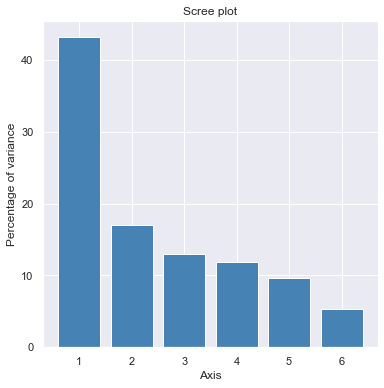

In [39]:
print(my_pca.eig_)
my_pca.plot_eigenvalues(type="percentage")

**Extraction des statistiques**

In [40]:
df_rows = my_pca.row_topandas()
df_rows.head(2)

,row_coord_dim1,row_coord_dim2,row_coord_dim3,row_coord_dim4,row_coord_dim5,row_coord_dim6,row_contrib_dim1,row_contrib_dim2,row_contrib_dim3,row_contrib_dim4,row_contrib_dim5,row_contrib_dim6,row_cos2_dim1,row_cos2_dim2,row_cos2_dim3,row_cos2_dim4,row_cos2_dim5,row_cos2_dim6
72,0.919912,-0.306218,0.183097,-1.332499,-0.322039,-0.232220,0.021760,0.006144,0.002861,0.166850,0.011925,0.011252,0.291132,0.032259,0.011533,0.610844,0.035679,0.018552
99,0.182466,0.104097,-0.155576,0.848570,-0.636561,-0.009108,0.000856,0.000710,0.002066,0.067665,0.046593,0.000017,0.027891,0.009078,0.020276,0.603227,0.339458,0.000069


Ce sont les coordonnées des lignes qui seront retenues pour les composantes principales (synthétiques)

In [41]:
df_cols = my_pca.col_topandas()
df_cols.head(2)

,col_coord_dim1,col_coord_dim2,col_coord_dim3,col_coord_dim4,col_coord_dim5,col_coord_dim6,col_contrib_dim1,col_contrib_dim2,col_contrib_dim3,col_contrib_dim4,col_contrib_dim5,col_contrib_dim6,col_cos2_dim1,col_cos2_dim2,col_cos2_dim3,col_cos2_dim4,col_cos2_dim5,col_cos2_dim6
diagonal,0.136658,0.949497,0.253501,-0.086544,0.089483,0.004496,0.720310,88.609933,8.226615,1.055747,1.381069,0.006326,0.018675,0.901545,0.064263,0.007490,0.008007,0.000020
height_left,-0.533523,0.309886,-0.781987,-0.039664,-0.078970,0.003332,10.978855,9.438400,78.281896,0.221755,1.075619,0.003474,0.284646,0.096029,0.611504,0.001573,0.006236,0.000011


**Etude des liaisons entre les variables**

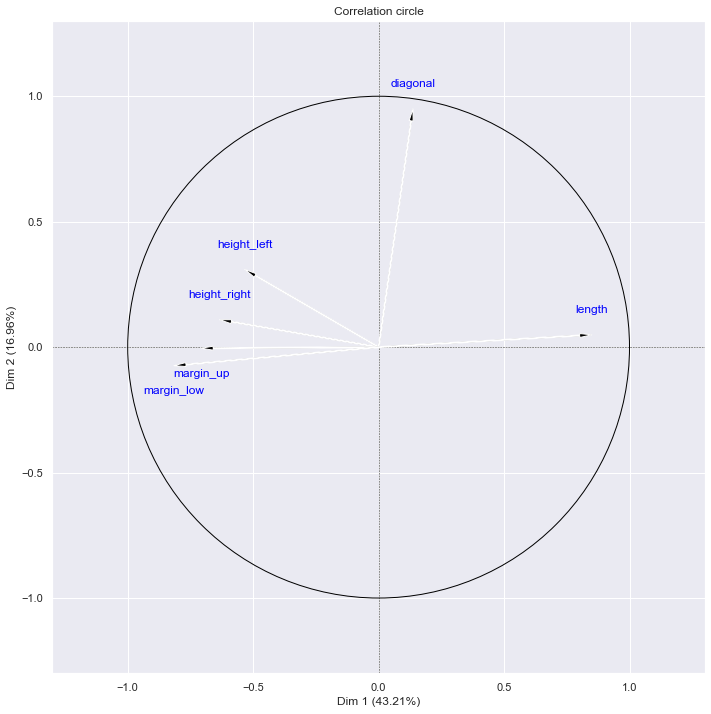

In [42]:
my_pca.correlation_circle(1, 2, figsize=(14, 12))

On observe :   
    - la variable 'length' tend positivement selon la dimension 1  
    - la variable 'diagonal' tend négativement selon la dimension 2  
    - les variables 'margin' et 'height' tendent négativement selon la dimension 1  

Avec 2 dimensions, près de 60 % de l'information est conservée

**Etudier la variabilité**

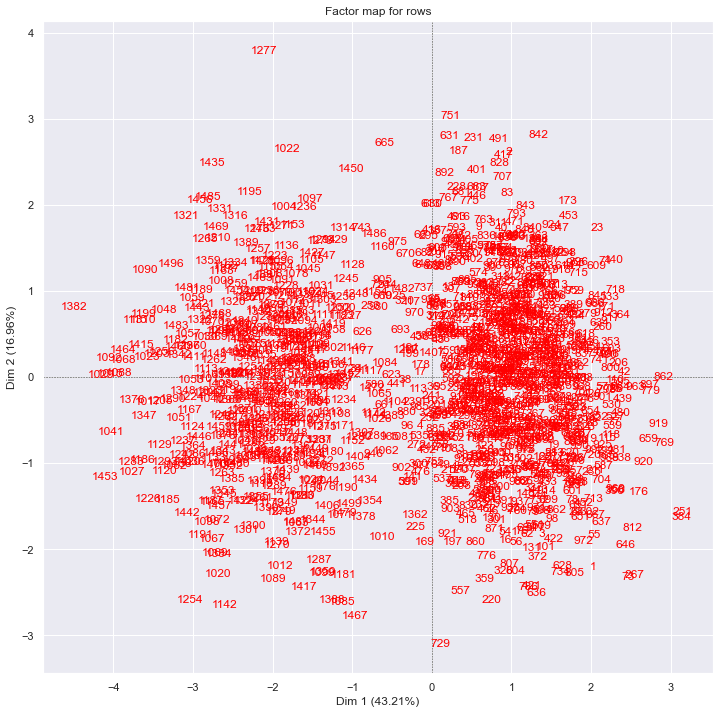

In [43]:
my_pca.mapping_row(num_x_axis=1, num_y_axis=2, figsize=(12, 12))

**Analyse des axes**

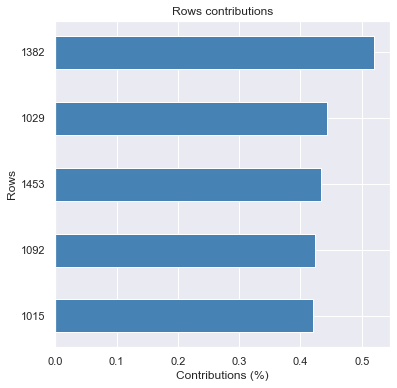

In [44]:
my_pca.plot_row_contrib(num_axis=1, nb_values=5)

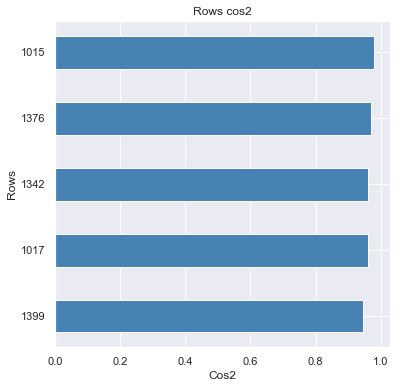

In [45]:
my_pca.plot_row_cos2(num_axis=1, nb_values=5)

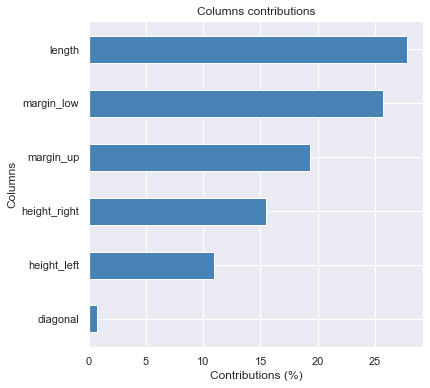

In [46]:
my_pca.plot_col_contrib(num_axis=1)

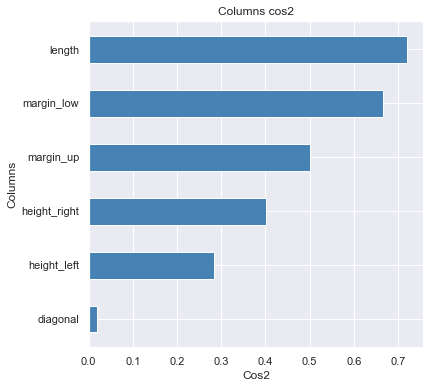

In [47]:
my_pca.plot_col_cos2(num_axis=1)

In [48]:
df_ACP = df_rows.iloc[:,0:6]
df_ACP.rename(columns={'row_coord_dim1': 'PC1',
                      'row_coord_dim2': 'PC2',
                       'row_coord_dim3': 'PC3',
                       'row_coord_dim4': 'PC4',
                       'row_coord_dim5': 'PC5',
                       'row_coord_dim6': 'PC6',
                      }, inplace=True)
df_ACP.head(2)

/Users/nipeti/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,PC1,PC2,PC3,PC4,PC5,PC6
72,0.919912,-0.306218,0.183097,-1.332499,-0.322039,-0.232220
99,0.182466,0.104097,-0.155576,0.848570,-0.636561,-0.009108


**Répartition des dimensions des billets et composition des variables synthètiques**

In [49]:
#n_components
from sklearn import decomposition
pca = decomposition.PCA(n_components=6)
pca.fit(XCR)
Components = pd.DataFrame(df_ACP, index=dfB.index, columns=["PC"+str(i+1) for i in range(6)])
Components.head(2)

,PC1,PC2,PC3,PC4,PC5,PC6
72,0.919912,-0.306218,0.183097,-1.332499,-0.322039,-0.232220
99,0.182466,0.104097,-0.155576,0.848570,-0.636561,-0.009108


In [118]:
dfB.columns[1:7]

Index(['diagonal', 'height_left', 'height_right', 'margin_up', 'length',
       'margin_low'],
      dtype='object')

In [51]:
PC1 = pca.components_[0]
PC1

array([-0.0848711 ,  0.33134356,  0.39381277,  0.43924936, -0.52751096,
        0.50666757])

**PC1** est une combinaison linéaire de  :  
- -0.085 * Diagonal   
- 0.33 * height_left  
- 0.39 * height_right  
- -0.43 * margin_low    
- _0.52 * margin_up  
- 0.5 * length  

In [52]:
PC2 = pca.components_[1]
PC2

array([ 0.94132849,  0.30721979,  0.10853873, -0.0043775 ,  0.04865929,
       -0.07313776])

In [53]:
PC3 = pca.components_[2]
PC3

array([-0.28682076,  0.88477057, -0.16656323, -0.27100638,  0.14968248,
       -0.10640619])

In [54]:
PC4 = pca.components_[3]
PC4

array([-0.10274954, -0.04709084,  0.86627893, -0.44409486,  0.1773263 ,
       -0.09011624])

In [55]:
PC5 = pca.components_[4]
PC5

array([-0.1175189 ,  0.10371207,  0.23437556,  0.70967147,  0.30166522,
       -0.57084649])

In [56]:
PC6 = pca.components_[5]
PC6

array([0.0079539 , 0.00589436, 0.00405525, 0.180949  , 0.75796642,
       0.62660188])

**Les résultats de l'ACP (composantes) sont utilisées pour le k-means. Les données sont déjà centrées et réduites.**

## K-Means (basé sur l'ACP)

In [57]:
X = df_ACP

In [58]:
from matplotlib.patches import Ellipse
K = np.arange(2,10,1)
K

array([2, 3, 4, 5, 6, 7, 8, 9])

In [59]:
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
for k in K:
    km_char = KMeans(n_clusters=k)
    km_char = km_char.fit(X)
    Sum_of_squared_distances.append(km_char.inertia_)
    
print(Sum_of_squared_distances)

[5801.57502775082, 5087.633505452949, 4674.195938512415, 4356.455335183687, 4103.210728909624, 3910.139656536926, 3752.15460984367, 3595.545169285478]


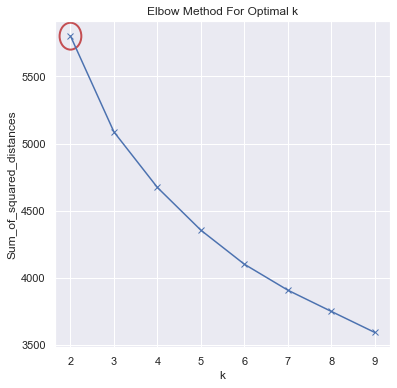

In [60]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.xticks(np.arange(2, 10, step=1))
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')

#On affiche l'ellipse pour Optimal K
ax = plt.gca()

ellipse = Ellipse(xy=(2, 5800), width=0.5, height=200, edgecolor='r', fc='None', lw=2)
ax.add_patch(ellipse)

Bien qu'un "coude" apparait pour k=3, k=2 serait retenu pour ne pas introduire de partitions supplémentaires par rapport à la  variable booléenne 'is_genuine'

In [61]:
#on lance la fonction K-means et on souhaite K classes
result = KMeans(n_clusters=2, random_state=42).fit(X)
#Affichage des classes
print(result.labels_)

[1 1 1 ... 0 0 0]


In [62]:
#Affichage des centres des classes
print(result.cluster_centers_)

[[-2.06716911 -0.0743082   0.09127802 -0.08660499  0.13924506 -0.04714884]
 [ 1.02123095  0.03671003 -0.04509352  0.04278493 -0.06879039  0.02329266]]


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

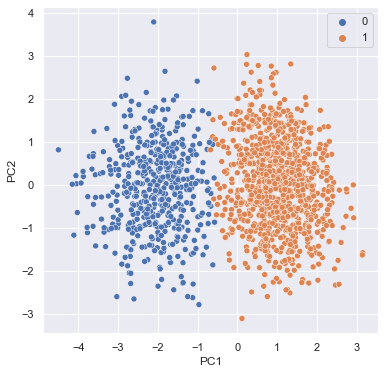

In [63]:
clusters = result.labels_
sns.scatterplot(data=X, x='PC1', y='PC2', hue=result.labels_)

#ou
#colors = ['royalblue', 'deeppink', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']
#vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

#plt.scatter(X['PC1'], X['PC2'], c=result.labels_, s=50, cmap='viridis')
#centers = result.cluster_centers_
#plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [64]:
df_ACP['kmeans'] = result.labels_
df_ACP.head(3)

<ipython-input-64-423049734a3b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ACP['kmeans'] = result.labels_


,PC1,PC2,PC3,PC4,PC5,PC6,kmeans
72,0.919912,-0.306218,0.183097,-1.332499,-0.322039,-0.232220,1
99,0.182466,0.104097,-0.155576,0.848570,-0.636561,-0.009108,1
151,0.398150,0.317110,0.765317,1.572609,-0.194692,-0.211393,1


In [65]:
from sklearn.metrics import silhouette_score
silhouette_score(df_ACP[["PC1","PC2"]],result.labels_ )

0.5392017912841085

Le score silhouette indique que le chevauchement des clusters est plus proche de 1 que de 0, la qualité du partitionnement pour cette classification est correcte sans être optimale.

In [66]:
#Fonction pour croiser des variables qualitatives et quantitatives en fonction d'une variable qualitative

def build_plot(explicative,a_expliquer,dfdata, nb_colors = 3):

    import numpy as np # pour gestion des listes
    import pandas as pd #pour manipuler les données / data framed
    import matplotlib.pyplot as plt #pour les sorties graphiques
    import seaborn as sns #pour les sorties graphiques

    #Charte graphique
    colors = [(0/255, 48/255, 73/255), (158/255, 183/255, 208/255), 
          (60/255, 213/255, 229/255), (126/255, 224/255, 74/255),
          (244/255, 96/255, 54/255), (186/255, 43/255, 52/255),
          (230/255, 80/255, 20/255)]

    colorsmod = [(45/255, 125/255, 160/255), (12/255, 80/255, 125/255),
             (0/255, 48/255, 73/255), (158/255, 183/255, 208/255),
             (60/255, 213/255, 229/255), (126/255, 224/255, 74/255)
             , (244/255, 96/255, 54/255), (18/255, 180/255, 152/255),
             (186/255, 43/255, 52/255), (230/255, 80/255, 20/255)]

    if (np.issubdtype(dfdata[explicative].dtype, np.number)) :
        plt.figure(figsize=(6,3))
        sns.boxplot(data=dfdata,x=explicative,y=a_expliquer,palette=colors[0:nb_colors],orient="h")
        plt.xlabel(explicative,fontsize=10)
        plt.ylabel(a_expliquer,fontsize=10)
        plt.title(explicative + " selon " + a_expliquer,fontsize=15)
    else :
        pd.crosstab(dfdata[a_expliquer], dfdata[explicative])\
        .apply(lambda r: r/r.sum(), axis=1).plot(kind='barh',stacked=True,legend=False, color=colorsmod,  figsize=(12,4))
        plt.figure(figsize=(6,3))
        plt.xlabel(explicative,fontsize=10)
        plt.ylabel(a_expliquer,fontsize=10)
        plt.title(explicative + " selon " + a_expliquer,fontsize=15)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

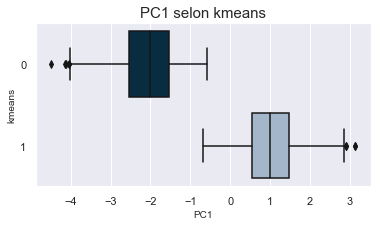

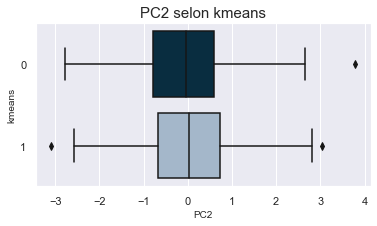

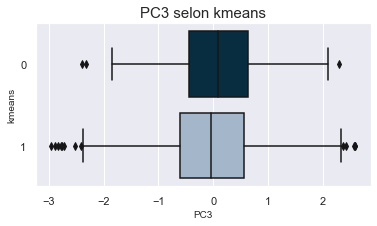

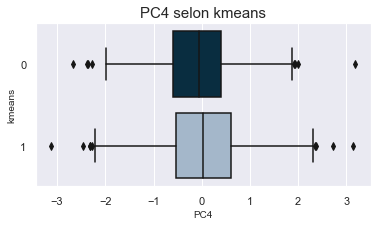

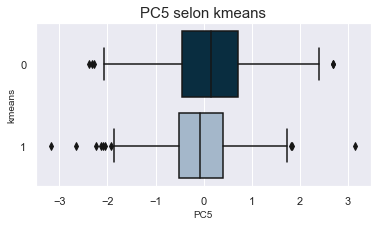

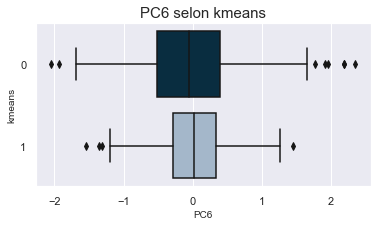

In [67]:
for item in ['PC1','PC2', 'PC3', 'PC4', 'PC5', 'PC6']:
    build_plot(explicative=item,a_expliquer="kmeans",
               dfdata=df_ACP,
               nb_colors=3)

On observe que seule la moyenne des individus des kmeans 0 et 1 de PC1 est visiblement différente

Ensuite, on rapatrie la colonne is_genuine sur le dataframe de l'ACP pour faire correspondre les k-means avec les données sur l'authenticité

In [68]:
df_is_genuine = dfB.iloc[:,0:1]
df_is_genuine.head(1)

,is_genuine
72,True


In [69]:
df = pd.concat([df_is_genuine['is_genuine'], df_ACP], axis=1)

In [70]:
df.head(10)

,is_genuine,PC1,PC2,PC3,PC4,PC5,PC6,kmeans
72,True,0.919912,-0.306218,0.183097,-1.332499,-0.322039,-0.232220,1
99,True,0.182466,0.104097,-0.155576,0.848570,-0.636561,-0.009108,1
151,True,0.398150,0.317110,0.765317,1.572609,-0.194692,-0.211393,1
197,True,0.258472,-1.909692,0.920138,-0.801616,-2.043937,0.392964,1
241,True,-0.007357,-0.213655,-0.530100,0.631632,0.028099,-0.704077,1
251,True,3.146557,-1.568372,1.171216,-2.204515,1.091322,-0.088936,1
284,True,0.938906,-0.298888,0.392555,-0.352643,-0.635860,0.197428,1
334,True,1.260270,-0.579025,0.540585,0.671619,-0.037274,0.125452,1
410,True,1.538996,1.461891,1.122167,-1.075392,0.288914,-0.166176,1
413,True,1.474807,0.594815,1.095588,-1.080690,0.088116,-0.149766,1


Kmeans 1 semble correspondre aux billets is_genuine = True  
Comparons les données classifiées avec le kmeans aux données de is_genuine avec une matrice de confusion

#### Matrice de confusion

Pour rappel : 

![matricedeconfusion](https://user.oc-static.com/upload/2017/03/02/14884666421501_P2C1-1.png)

On observe l'appartenance des billets aux classes is_genuine et kmeans

In [71]:
df_cont = pd.crosstab(df.kmeans,df.is_genuine)
df_cont

is_genuine,False,True
kmeans,,
0,486,10
1,14,990


On observe que les billets de kmeans 1 correspondent majoritairement aux billets avec is_genuine = True et les billets de kmeans O correspondent majoritairement aux billets avec is_genuine = False  
On obtient donc : 

In [72]:
#Vrai négatif
TN = df_cont.iloc[0,0]
#Vrai positifs
TP = df_cont.iloc[1,1]
#Faux négatif (négatif à tort)
FN = df_cont.iloc[0,1]
#Faux positifs (positif à tort)
FP = df_cont.iloc[1,0]

TN, TP, FN, FP

(486, 990, 10, 14)

Listons les 10 billets de kmeans 0 et 'is genuine' = True (faux positifs) dans un dataframe df_FP

In [73]:
kmeans = [0]
df_FP = df[df['kmeans'].isin(kmeans)].sort_values('is_genuine', ascending=False).head(15)
df_FP.head(2)

,is_genuine,PC1,PC2,PC3,PC4,PC5,PC6,kmeans
946,True,-0.737049,-0.889817,0.617338,1.930076,-1.301244,-0.275170,0
0,True,-1.647524,0.746876,-2.392915,3.186405,-0.305766,-0.011945,0


#### Score Kmeans

In [74]:
#Calcul d'un score de précision 
#accuracy = (vrais négatifs+vrais positifs) / (vrais négatifs+vrais positifs+faux négatifs+faux positifs)
accuracy = (TN+TP)/(TN+TP+FN+FP)
accuracy

0.984

# III. Méthode 2

## Echantillonage

On crée un objet **X** en partant du dataframe dfB pour garder les variables explicatives (hors is_genuine, la variable à expliquer)

In [75]:
X = dfB.iloc[:,1:7]
X.head(1)

,diagonal,height_left,height_right,margin_up,length,margin_low
72,171.94,103.89,103.45,3.25,112.79,4.064954


On crée un objet **Y** avec la variable à expliquer (is_genuine, bool)

In [76]:
Y = dfB.is_genuine
Y.head(1)

72    True
Name: is_genuine, dtype: bool

On regarde la répartition des classes à prédire

In [77]:
Y.value_counts(normalize=True)

True     0.666667
False    0.333333
Name: is_genuine, dtype: float64

On scinde l'échantillon en train / test

In [78]:
from sklearn.model_selection import train_test_split
#80% des données pour l’apprentissage
#20% des données pour l'échantillon test 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.8, random_state = 42, stratify = Y) 
#Pour voir les modèles les plus performants, mettre test_size < 0.9 

On affiche un extrait de *X_train*

In [79]:
print(X_train.shape)
X_train.head(2)

(300, 6)


,diagonal,height_left,height_right,margin_up,length,margin_low
555,172.07,104.18,104.10,2.70,113.99,4.47
22,172.10,103.96,103.71,2.89,112.68,3.93


On affiche un extrait de *X_test*.

In [80]:
print(X_test.shape)
X_test.head()

(1200, 6)


,diagonal,height_left,height_right,margin_up,length,margin_low
368,171.65,103.58,104.21,3.30,113.42,3.91
725,171.73,103.60,103.34,3.15,112.89,3.82
483,172.14,103.91,103.65,3.23,113.54,4.19
1393,171.67,104.08,104.73,3.31,111.81,4.93
907,171.99,104.44,103.88,2.89,113.01,4.04


On vérifie que les échantillons soient bien statifiés.

In [81]:
print(y_train.shape)
y_train.value_counts(normalize=True)

(300,)


True     0.666667
False    0.333333
Name: is_genuine, dtype: float64

In [82]:
print(y_test.shape)
y_test.value_counts(normalize=True)

(1200,)


True     0.666667
False    0.333333
Name: is_genuine, dtype: float64

## Regression logistique

In [83]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

reg_log2 = smf.glm('is_genuine~diagonal+height_left+height_right+margin_low+margin_up+length',
                   data=dfB, family=sm.families.Binomial()).fit()
print(reg_log2.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1500
Model:                                                   GLM   Df Residuals:                     1493
Model Family:                                       Binomial   Df Model:                            6
Link Function:                                         logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -39.524
Date:                                       Mon, 13 Dec 2021   Deviance:                       79.048
Time:                                               13:33:45   Pearson chi2:                 2.81e+03
No. Iterations:                                           10                                         
Covariance Type:                                   nonrobust                      

On observe : 

- Des variables (margin up, margin low, length) ont des p-valeurs qui sont inférieures à un niveau de test de 5 %, ce qui nous indique qu'elles sont bien significatives   

- D'autres (diagonal, height- left, height_right) ne sont pas en dessous de ce seuil.

In [84]:
from sklearn.linear_model import LogisticRegression

reg_log = LogisticRegression()
reg_log_model = reg_log.fit(X_train, y_train)
y_pred = reg_log_model.predict(X_test)

#### Evaluation du modèle et matrice de confusion

On évalue le modèle avec une matrice de confusion entre predictions et observations sur Y test/pred

In [85]:
pd.crosstab(y_test,y_pred, colnames=['observations'], rownames=['predictions'], margins=True)

observations,False,True,All
predictions,,,
False,389,11,400
True,3,797,800
All,392,808,1200


ou

In [86]:
from sklearn.metrics import confusion_matrix
mat_conf = pd.DataFrame(confusion_matrix(y_test,y_pred), 
                  columns=['obs_0','obs_1'],
                  index=['pred_0','pred_1'])
mat_conf

,obs_0,obs_1
pred_0,389,11
pred_1,3,797


Sur l'échantillon Y, on obtient :  

In [87]:
#Vrai négatif
TN = mat_conf.iloc[0,0]
#Vrai positifs
TP = mat_conf.iloc[1,1]
#Faux négatif (négatif à tort)
FN = mat_conf.iloc[0,1]
#Faux positifs (positif à tort)
FP = mat_conf.iloc[1,0]

TN, TP, FN, FP

(389, 797, 11, 3)

#### Scores Regression logistique

In [88]:
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, f1_score, recall_score, precision_score #make_scorer

print("accuracy : " + str(accuracy_score(y_test,y_pred)))
print('recall_score : ' + str(recall_score(y_test,y_pred,average='binary', pos_label=1)))
print('precision_score : ' + str(precision_score(y_test,y_pred,average='binary', pos_label=1)))
print('f1_score : ' + str(f1_score(y_test,y_pred,average='binary', pos_label=1)))

accuracy : 0.9883333333333333
recall_score : 0.99625
precision_score : 0.9863861386138614
f1_score : 0.9912935323383085


- **Le succès** permet de connaître la proportion de bonnes prédictions par rapport à toutes les prédictions.

- **Le rappel**, ou le nombre de fois où un billet a été reconnu par rapport au nombre de fois où il aurait dû être reconnu / le nombre de documents correctement attribués à la classe relative par rapport au nombre total de documents appartenant à la classe relative (total true positive)

- **La précision**, ou le nombre de fois où un billet a été reconnu (c’était vraiment lui) par rapport au nombre de fois où il a été prédit (même si ce n’était pas vraiment lui) / le nombre de documents correctement attribués à la classe relative par rapport au nombre total de documents prédits comme appartenant à la classe relative (total predicted positive)

- **Le F1_score**, comme une moyenne harmonique de la précision et du rappel (ne prenant pas en compte le nombre de vrais négatifs)

**Le modèle de régression logistique présente un score "accuracy" quasi-équivalent à celui du kmeans**

#### Coefficient de détermination

On s'interesse aux coefficients de détermination de chaque variable :

In [89]:
coef = pd.DataFrame(reg_log_model.coef_[0,] ,index = X_train.columns, columns=['Coefficient'])
coef.loc['Constante'] = reg_log_model.intercept_
coef

,Coefficient
diagonal,-0.683950
height_left,-1.021507
height_right,-1.371126
margin_up,-1.405396
length,3.395810
margin_low,-2.353956
Constante,-0.022490


On observe que les valeurs des variables length et margin low sont les plus éloignées de la valeur de la constante

#### Estimations des probabilités

predict_proba() renvoie une probabilité des classes auxquelles appartient l'instance, pour autant de lignes que l'échantillon de test pour X_test

In [90]:
#Probabilité d'un billet d'appartenir à la classe faux/vrai, la somme des couples fait 1
reg_log_model.predict_proba(X_test)[0:10].round(3)

array([[0.006, 0.994],
       [0.007, 0.993],
       [0.006, 0.994],
       [0.981, 0.019],
       [0.032, 0.968],
       [0.001, 0.999],
       [0.939, 0.061],
       [0.996, 0.004],
       [0.998, 0.002],
       [0.998, 0.002]])

# IV. Methodes additionnelles

## KNN

In [91]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [92]:
y_pred = knn_model.predict(X_test)

from sklearn.metrics import confusion_matrix
knn = pd.DataFrame(confusion_matrix(y_test,y_pred), columns=['obs_0','obs_1'], index=['pred_0','pred_1'])
knn

,obs_0,obs_1
pred_0,392,8
pred_1,4,796


In [93]:
#Vrai négatif
TN = knn.iloc[0,0]
#Vrai positifs
TP = knn.iloc[1,1]
#Faux négatif (négatif à tort)
FN = knn.iloc[0,1]
#Faux positifs (positif à tort)
FP = knn.iloc[1,0]

TN, TP, FN, FP

(392, 796, 8, 4)

#### Scores KNN

In [94]:
print("accuracy : " + str(accuracy_score(y_test,y_pred)))
print('recall_score : ' + str(recall_score(y_test,y_pred,average='binary', pos_label=1)))
print('precision_score : ' + str(precision_score(y_test,y_pred,average='binary', pos_label=1)))
print('f1_score : ' + str(f1_score(y_test,y_pred,average='binary', pos_label=1)))

accuracy : 0.99
recall_score : 0.995
precision_score : 0.9900497512437811
f1_score : 0.9925187032418954


#### Estimations des probabilités

Pour un KNN, *predict_proba()* renvoie la proportion des classes du sous ensemble auquel appartient l'instance (plus qu'une réelle probabilité)

In [95]:
knn_model.predict_proba(X_test)[0:10].round(3)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

## Decision Tree

In [96]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

In [97]:
decisiontree = DecisionTreeClassifier(max_depth=3 , min_samples_leaf=10, min_samples_split=20)
decisiontree = decisiontree.fit(X_train,y_train)

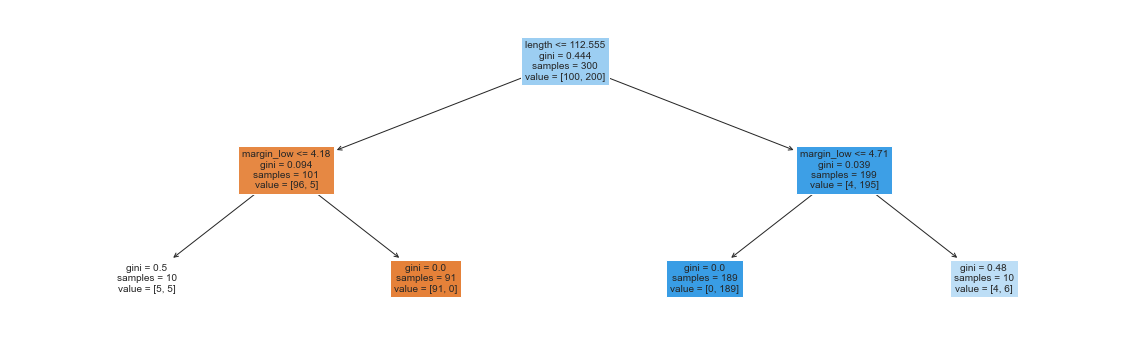

In [120]:
plt.figure(figsize=(20,6))
plot_tree(decisiontree,feature_names = list(X.columns),filled=True, fontsize=10)
plt.show()

In [99]:
dt = pd.crosstab(y_test,y_pred, colnames=['obs'], rownames=['pred'], margins=True)
dt

obs,False,True,All
pred,,,
False,392,8,400
True,4,796,800
All,396,804,1200


In [100]:
#Vrai négatif
TN = dt.iloc[0,0]
#Vrai positifs
TP = dt.iloc[1,1]
#Faux négatif (négatif à tort)
FN = dt.iloc[0,1]
#Faux positifs (positif à tort)
FP = dt.iloc[1,0]

TN, TP, FN, FP

(392, 796, 8, 4)

#### Scores Decision Tree

In [101]:
print("accuracy : " + str(accuracy_score(y_test,y_pred)))
print('recall_score : ' + str(recall_score(y_test,y_pred,average='binary', pos_label=1)))
print('precision_score : ' + str(precision_score(y_test,y_pred,average='binary', pos_label=1)))
print('f1_score : ' + str(f1_score(y_test,y_pred,average='binary', pos_label=1)))

accuracy : 0.99
recall_score : 0.995
precision_score : 0.9900497512437811
f1_score : 0.9925187032418954


#### Estimations des probabilités

Pour un arbre de décision, *predict_proba()* renvoie la proportion des classes du sous ensemble auquel appartient l'instance (plus qu'une réelle probabilité)

In [102]:
y_pred_proba = decisiontree.predict_proba(X_test)
y_pred_proba[0:10]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

## Random Forest

In [103]:
from sklearn.ensemble import RandomForestClassifier

rfclf = RandomForestClassifier(random_state=0)
rf_model = rfclf.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

rf = pd.crosstab(y_test,y_pred, colnames=['obs'], rownames=['pred'], margins=True)
rf

obs,False,True,All
pred,,,
False,394,6,400
True,15,785,800
All,409,791,1200


In [104]:
#Vrai négatif
TN = rf.iloc[0,0]
#Vrai positifs
TP = rf.iloc[1,1]
#Faux négatif (négatif à tort)
FN = rf.iloc[0,1]
#Faux positifs (positif à tort)
FP = rf.iloc[1,0]

TN, TP, FN, FP

(394, 785, 6, 15)

#### Scores Random Forest

In [105]:
print("accuracy : " + str(accuracy_score(y_test,y_pred)))
print('recall_score : ' + str(recall_score(y_test,y_pred,average='binary', pos_label=1)))
print('precision_score : ' + str(precision_score(y_test,y_pred,average='binary', pos_label=1)))
print('f1_score : ' + str(f1_score(y_test,y_pred,average='binary', pos_label=1)))

accuracy : 0.9825
recall_score : 0.98125
precision_score : 0.9924146649810367
f1_score : 0.9868007542426146


In [106]:
rf_model.feature_importances_

array([0.01238562, 0.02814637, 0.05972157, 0.11721632, 0.52680526,
       0.25572486])

#### Feature Importances

Feature importances are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

In [107]:
pd.DataFrame(rf_model.feature_importances_, 
             index=X_train.columns.tolist(),
             columns=['Importances']).sort_values(by = 'Importances', ascending=False)

,Importances
length,0.526805
margin_low,0.255725
margin_up,0.117216
height_right,0.059722
height_left,0.028146
diagonal,0.012386


#### Estimations des probabilités

In [108]:
#Probabilité d'un billet d'appartenir à la classe faux/vrai, la somme des couples fait 1
rf_model.predict_proba(X_test)[0:10].round(3)

array([[0.07, 0.93],
       [0.  , 1.  ],
       [0.04, 0.96],
       [0.98, 0.02],
       [0.01, 0.99],
       [0.  , 1.  ],
       [0.99, 0.01],
       [0.99, 0.01],
       [0.95, 0.05],
       [1.  , 0.  ]])

## Gradient Boosting

In [109]:
from sklearn.ensemble import GradientBoostingClassifier


gclf = GradientBoostingClassifier(random_state=0, max_depth=6, min_samples_leaf=5, min_samples_split=10,
                       n_estimators=50)

gclf = gclf.fit(X_train, y_train)
y_pred = gclf.predict(X_test)

gb = pd.crosstab(y_test,y_pred, colnames=['obs'], rownames=['pred'], margins=True)
gb

obs,False,True,All
pred,,,
False,392,8,400
True,20,780,800
All,412,788,1200


In [110]:
#Vrai négatif
TN = gb.iloc[0,0]
#Vrai positifs
TP = gb.iloc[1,1]
#Faux négatif (négatif à tort)
FN = gb.iloc[0,1]
#Faux positifs (positif à tort)
FP = gb.iloc[1,0]

TN, TP, FN, FP

(392, 780, 8, 20)

#### Scores Gradient Boosting

In [111]:
print("accuracy : " + str(accuracy_score(y_test,y_pred)))
print('recall_score : ' + str(recall_score(y_test,y_pred,average='binary', pos_label=1)))
print('precision_score : ' + str(precision_score(y_test,y_pred,average='binary', pos_label=1)))
print('f1_score : ' + str(f1_score(y_test,y_pred,average='binary', pos_label=1)))

accuracy : 0.9766666666666667
recall_score : 0.975
precision_score : 0.9898477157360406
f1_score : 0.982367758186398


#### Feature Importances

In [112]:
pd.DataFrame(gclf.feature_importances_, 
             index=X_train.columns.tolist(),
             columns=['Importances']).sort_values(by = 'Importances', ascending=False)

,Importances
length,0.888616
margin_low,0.105799
margin_up,0.002680
height_right,0.002029
height_left,0.000724
diagonal,0.000152


# V. Performance

## Courbe ROC

In [113]:
def print_roc_curv(lst_proba,lst_label,y_test):
    
    from scipy import interp
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc
    from seaborn import color_palette
    import itertools
    
    colors = itertools.cycle(color_palette('bright'))
    cpt=0
    for i in lst_proba:
        probas = i #pour calculer la proba d'appartenance à la classe 0 et à la classe 1 de chaque individu de l'échantillon test
        #print(probas1[:, 1]) #seule la proba d'appartenance à la classe 1 nous intéresse

        # Construction de la courbe ROC et calcul de l'AUC pour un modèle
        fpr, tpr, thresholds = roc_curve(y_test,probas[:, 1]) #fpr = False Positive Rate ; tpr = True Positive Rate
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, alpha=0.8, label=str(lst_label[cpt])+ '(AUC = %0.2f)' % (roc_auc), color=next(colors))
        cpt=cpt+1
     
    plt.plot([0, 1], [0, 1], linestyle='-', lw=2, color='black',
             label='Chance', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Comparaison de modèles : courbes ROC')
    plt.legend(loc="lower right")
    plt.show()

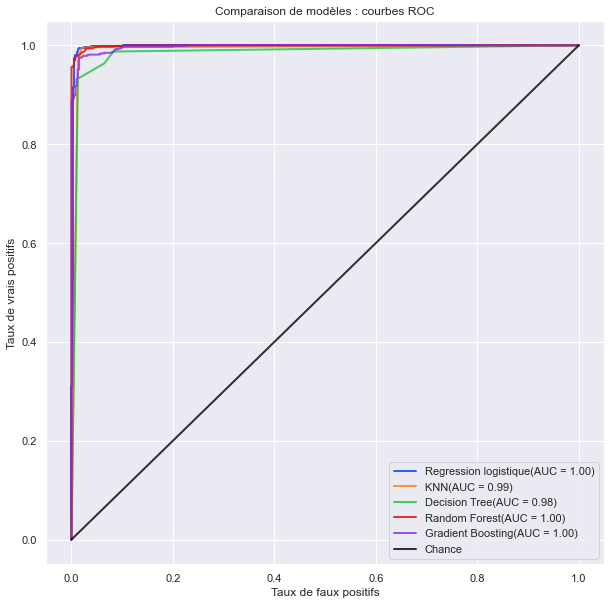

In [114]:
from sklearn.metrics import roc_curve, auc
lst_proba = []
lst_label = []

#Model 2 : Regression Logistique
lst_proba.append(reg_log_model.predict_proba(X_test))
lst_label.append("Regression logistique")

#Model  3 : KNN
lst_proba.append(knn_model.predict_proba(X_test))
lst_label.append("KNN")

#Model  4 : Decision Tree
lst_proba.append(decisiontree.predict_proba(X_test))
lst_label.append("Decision Tree")

#Model  5 : Random Forest
lst_proba.append(rf_model.predict_proba(X_test))
lst_label.append("Random Forest")

#Model  6 : Gradient Boosting
lst_proba.append(gclf.predict_proba(X_test))
lst_label.append("Gradient Boosting")

plt.figure(figsize=(10,10))
print_roc_curv(lst_proba,lst_label,y_test)

# VI. Production

In [115]:
#Test de l’algorithme avec un jeu de données de production : une variable id et pas de variable is_genuine
dfB_prod = pd.read_csv('./billets_production.csv', sep=',', encoding='UTF-8')
dfB_prod.head(10)

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5
